In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
from fbprophet import Prophet
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df = pd.read_excel('revenue.xls')

In [4]:
df.head()

,Net Revenue USD for FY18 Revenue Budget (Fiscal Month),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
1,NaN,Net Revenue USD,Net Revenue USD,Net Revenue USD,Net Revenue USD,Net Revenue USD,Net Revenue USD,Net Revenue USD
2,FY2010-Jan,377939,320808,NaN,880817,1.80757e+06,259958,258467
3,FY2010-Feb,337159,335724,NaN,837174,1.76726e+06,256983,275816
4,FY2010-Mar,387546,384028,NaN,915134,1.89768e+06,282160,279183


In [34]:
df = pd.read_excel('revenue.xls', skiprows=[0,2])

In [6]:
df.head()

,Unnamed: 0,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
0,FY2010-Jan,377939.015020,320807.8189,NaN,880816.522432,1.807572e+06,259957.775881,258467.166159
1,FY2010-Feb,337158.936772,335723.5138,NaN,837174.111218,1.767264e+06,256983.176286,275815.595799
2,FY2010-Mar,387546.046572,384027.6010,NaN,915134.147753,1.897677e+06,282159.755199,279183.037151
3,FY2010-Apr,393196.477598,382730.0591,NaN,875126.433038,1.853915e+06,280891.962443,264815.488010
4,FY2010-May,395323.949791,394245.8230,NaN,860353.683727,1.908385e+06,284354.468484,273353.954516


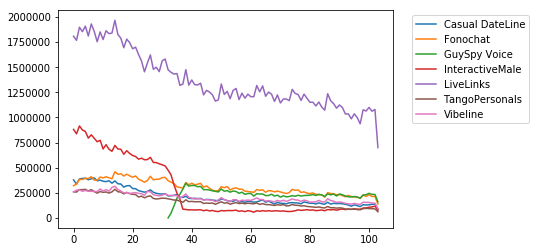

In [7]:
df.iloc[:,1::].plot(legend=False)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [8]:
df.index

RangeIndex(start=0, stop=108, step=1)

In [9]:
df.columns

Index(['Unnamed: 0', 'Casual DateLine', 'Fonochat', 'GuySpy Voice',
       'InteractiveMale', 'LiveLinks', 'TangoPersonals', 'Vibeline'],
      dtype='object')

In [10]:
df.fillna(0, inplace=True)

In [11]:
df.tail()

,Unnamed: 0,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
103,FY2018-Aug,86893.175322,137636.0391,160546.3467,77545.124952,699939.017528,61203.852129,92391.97591
104,FY2018-Sep,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000
105,FY2018-Oct,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000
106,FY2018-Nov,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000
107,FY2018-Dec,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000


Drop empty rows as well as last actual month since it was incomplete:

In [12]:
df.drop(range(103,108),inplace=True)

In [13]:
df.tail()

,Unnamed: 0,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
98,FY2018-Mar,131808.114141,227855.2228,228137.5641,98422.249048,1.075804e+06,92015.697041,157073.464099
99,FY2018-Apr,128607.926960,213157.1158,231256.7091,99759.583812,1.064065e+06,94898.986691,154658.066499
100,FY2018-May,130898.471726,231106.1515,244565.0256,106058.908376,1.099469e+06,93076.792719,154337.115565
101,FY2018-Jun,134728.611788,212894.4514,234758.8107,109454.885254,1.061791e+06,91937.749841,148042.361288
102,FY2018-Jul,137942.550475,215138.8731,233507.8302,117685.164361,1.079418e+06,90509.981526,146004.308862


In [14]:
df.iat[102,0]

'FY2018-Jul'

In [15]:
import calendar
mnths={name: str(num) for num, name in enumerate(calendar.month_abbr)}

In [16]:
mnths[df.iat[102,0][-3::]]

'7'

In [17]:
txt='FY2018-Dec'
txt[2:6]+'-'+mnths[txt[-3::]]

'2018-12'

In [18]:
from time import strptime
df['Unnamed: 0'].head(n=12).apply(lambda x: x[2:7] + str(strptime(x[-3::],"%b").tm_mon).zfill(2))

0     2010-01
1     2010-02
2     2010-03
3     2010-04
4     2010-05
5     2010-06
6     2010-07
7     2010-08
8     2010-09
9     2010-10
10    2010-11
11    2010-12
Name: Unnamed: 0, dtype: object

In [19]:
df['Unnamed: 0'] = df['Unnamed: 0'].apply(lambda x: x[2:7] + str(strptime(x[-3::],"%b").tm_mon).zfill(2))

In [20]:
df.columns=['date', 'Casual DateLine', 'Fonochat', 'GuySpy Voice',
       'InteractiveMale', 'LiveLinks', 'TangoPersonals', 'Vibeline']

In [21]:
df.head()

,date,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
0,2010-01,377939.015020,320807.8189,0.0,880816.522432,1.807572e+06,259957.775881,258467.166159
1,2010-02,337158.936772,335723.5138,0.0,837174.111218,1.767264e+06,256983.176286,275815.595799
2,2010-03,387546.046572,384027.6010,0.0,915134.147753,1.897677e+06,282159.755199,279183.037151
3,2010-04,393196.477598,382730.0591,0.0,875126.433038,1.853915e+06,280891.962443,264815.488010
4,2010-05,395323.949791,394245.8230,0.0,860353.683727,1.908385e+06,284354.468484,273353.954516


Instantiate a new Prophet object:

In [22]:
ts = Prophet(seasonality_mode='multiplicative')
ts.fit(df[['date', 'LiveLinks']].rename(columns={"date": "ds", "LiveLinks": "y"}))

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [23]:
future = ts.make_future_dataframe(periods=12, freq='M')
future.tail(n=14)

,ds
101,2018-06-01
102,2018-07-01
103,2018-07-31
104,2018-08-31
105,2018-09-30
106,2018-10-31
107,2018-11-30
108,2018-12-31
109,2019-01-31
110,2019-02-28


In [24]:
forecast=ts.predict(future)

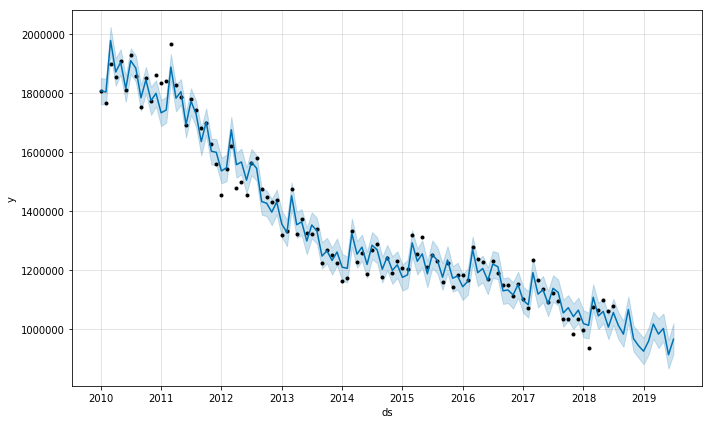

In [25]:
fig = ts.plot(forecast)

(808755.4178949471, 1900000)

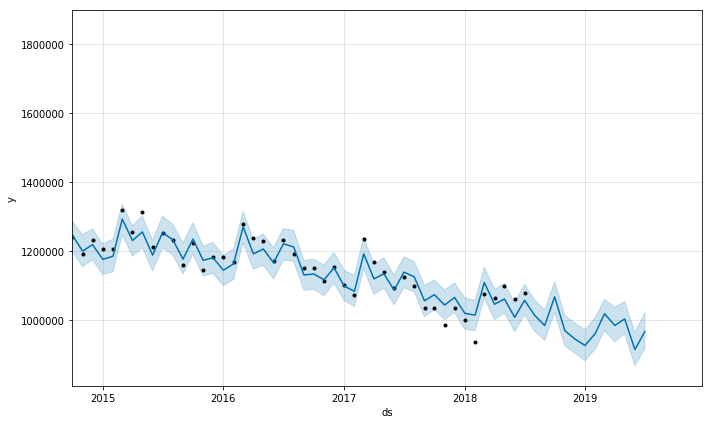

In [26]:
fig2 = ts.plot(forecast)
fig2ax=plt.gca()
fig2ax.set_xlim(left=fig2ax.get_xlim()[0]+(fig2ax.get_xlim()[1]-fig2ax.get_xlim()[0])/2)
fig2ax.set_ylim(top=1900000)

In [27]:
df['totalrev'] = df.iloc[:,1::].sum(axis='columns')

In [28]:
df.head()

,date,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline,totalrev
0,2010-01,377939.015020,320807.8189,0.0,880816.522432,1.807572e+06,259957.775881,258467.166159,3.905560e+06
1,2010-02,337158.936772,335723.5138,0.0,837174.111218,1.767264e+06,256983.176286,275815.595799,3.810120e+06
2,2010-03,387546.046572,384027.6010,0.0,915134.147753,1.897677e+06,282159.755199,279183.037151,4.145728e+06
3,2010-04,393196.477598,382730.0591,0.0,875126.433038,1.853915e+06,280891.962443,264815.488010,4.050676e+06
4,2010-05,395323.949791,394245.8230,0.0,860353.683727,1.908385e+06,284354.468484,273353.954516,4.116017e+06


In [29]:
revTS = Prophet(seasonality_mode='multiplicative')
revTS.fit(df[['date', 'totalrev']].rename(columns={"date": "ds", "totalrev": "y"}))

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [30]:
futurerev=revTS.make_future_dataframe(periods=18, freq='M')

In [31]:
revforecast = revTS.predict(futurerev)

(1340983.3278656015, 2800000)

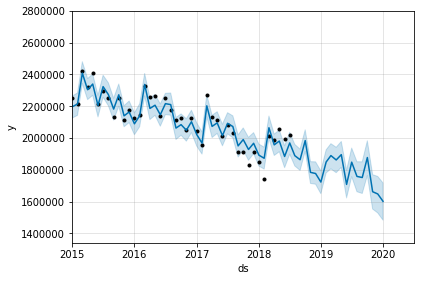

In [32]:
revfig = plt.figure()
ax = revfig.add_subplot(111)
revplot=revTS.plot(revforecast, ax=ax)
ax.set_xlim(left=ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])/2)
ax.set_ylim(top=2800000)

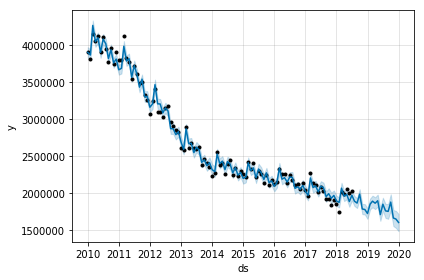

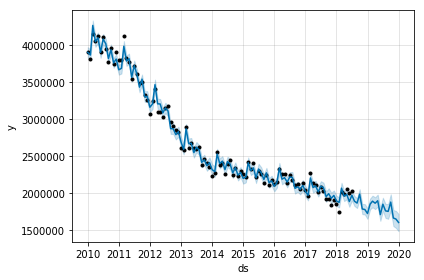

In [33]:
revfig, ax = plt.subplots()
revTS.plot(revforecast, ax=ax)

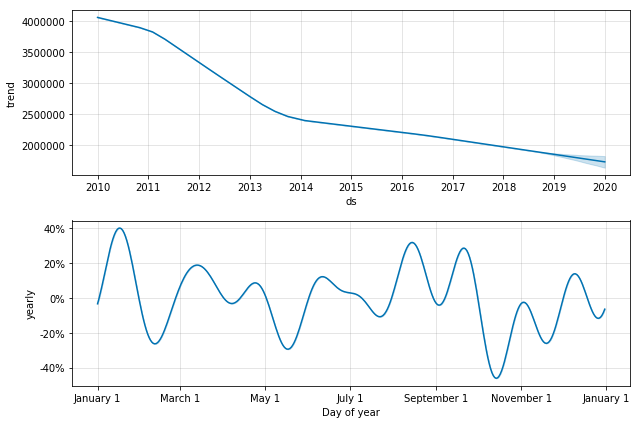

In [69]:
revTS.plot_components(revforecast);

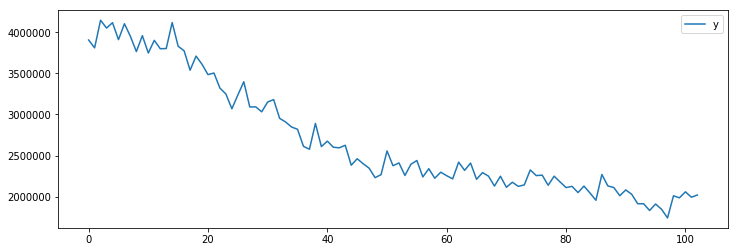

In [72]:
axx=df[['date', 'totalrev']].rename(columns={"date": "ds", "totalrev": "y"}).plot(figsize=(12,4))

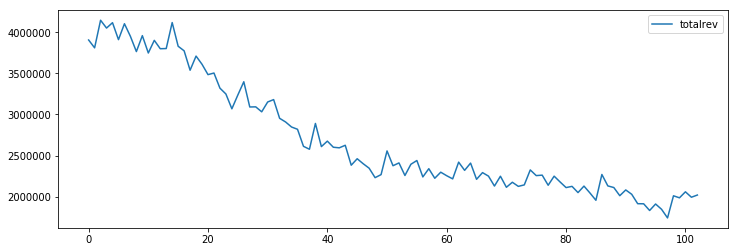

In [70]:
df[['date', 'totalrev']].plot(figsize=(12,4))

In [72]:
revforecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-01,4.064350e+06,3.824300e+06,3.970655e+06,4.064350e+06,4.064350e+06,-0.040501,-0.040501,-0.040501,-0.040501,-0.040501,-0.040501,0.0,0.0,0.0,3.899741e+06
1,2010-02-01,4.046696e+06,3.789764e+06,3.931622e+06,4.046696e+06,4.046696e+06,-0.045445,-0.045445,-0.045445,-0.045445,-0.045445,-0.045445,0.0,0.0,0.0,3.862793e+06
2,2010-03-01,4.030750e+06,4.197525e+06,4.333736e+06,4.030750e+06,4.030750e+06,0.057399,0.057399,0.057399,0.057399,0.057399,0.057399,0.0,0.0,0.0,4.262112e+06
3,2010-04-01,4.013096e+06,3.972221e+06,4.112113e+06,4.013096e+06,4.013096e+06,0.007549,0.007549,0.007549,0.007549,0.007549,0.007549,0.0,0.0,0.0,4.043389e+06
4,2010-05-01,3.996011e+06,4.030015e+06,4.163447e+06,3.996011e+06,3.996011e+06,0.025148,0.025148,0.025148,0.025148,0.025148,0.025148,0.0,0.0,0.0,4.096502e+06


In [ ]:
    fcst_t = fcst['ds'].dt.to_pydatetime()
????